In [3]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../../charm/") 
sys.path.append(src_path)
# sys.path.append(root_dir)
# from combined_models import *
# from all_models import *
from charm import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline




In [4]:
test_id = 1







In [5]:
# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params


device_id = torch.device("cuda")
ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
num_cond_Ntot = num_cond
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1



/tmp/ipykernel_3932378/1025593458.py:103: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_3932378/1025593458.py:108: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [6]:
import pickle as pk

ji_array = []
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, df_vh_train, ind_subsel_all_train, ind_subsel_fid_train, cosmo_val_all_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria, is_HR = is_HR,  vel_type='diff',
    get_density=False,
    get_halos=True
    )


import pickle as pk


df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, df_vh_train_FP, ind_subsel_all_train_FP, ind_subsel_fid_train_FP, cosmo_val_all_train_FP = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria,
    indsubsel_all_inp=ind_subsel_all_train,
    indsubsel_fid_inp=ind_subsel_fid_train,
    is_HR = is_HR,  vel_type='diff',
    get_density=True,
    get_halos=False
    )
if cosmo_val_all_train_FP is None:
    cosmo_val_all_train_FP = cosmo_val_all_train



0it [00:00, ?it/s]


In [7]:
nsims_per_batch, nbatches_train = 512, 1
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=df_vh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True
    )


# # Prepare the density and halo data
return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, df_v_inp=df_vh_train_FP, nsims=nsims_per_batch,
    nbatches=nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
    )

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
    cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

    cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])





In [8]:
# return_dict_train['df_d_all_nsh'].shape
# return_dict_train['Nhalo_train_mg_arr'].shape
density_train_rs = return_dict_train_FP['df_d_all_nsh'][0,:,0,...].reshape(512, 4096)
Nhalo_train_mg_arr_rs = return_dict_train['Nhalo_train_mg_arr'][0,:,:,0]
M1_norm_rs = return_dict_train['M1_halos_all_norm'][0,...]
Mdiff1_norm_rs = return_dict_train['M_diff_halos_all_norm_masked'][0,..., 0]
vhalos_diff_norm_rs = return_dict_train['v_halos_all_norm_masked'][0,..., 0, 0]




In [9]:
# return_dict_train.keys()
vhalos_diff_norm_rs.shape, Mdiff1_norm_rs.shape


((512, 4096), (512, 4096))

In [10]:
size = 10000
random_numbers = (np.random.choice(return_dict_train['mu_all'], size=size)).astype(np.float32)
# add gaussian noise
random_numbers += return_dict_train['sig_all'][0] * np.random.randn(size) 




In [11]:
# return_dict_train['sig_all']
# write a function for gaussian distribution given mean and variance
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (np.sqrt(2*np.pi) * sig)




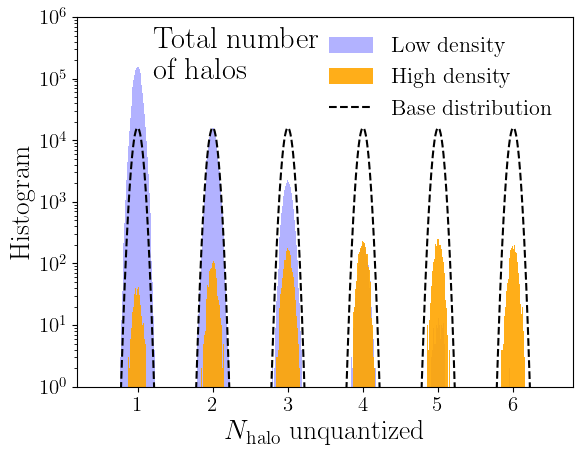

In [12]:
pl.figure()
# _ = pl.hist(Nhalo_train_mg_arr_rs.flatten(), bins=500, range=(0.5,6.5))
indsel = np.where(density_train_rs < 0.5)
_ = pl.hist(Nhalo_train_mg_arr_rs[indsel].flatten(), bins=500, range=(0.5,6.5), alpha=0.3, color='blue', label='Low density')

indsel = np.where(density_train_rs > 1.5)
_ = pl.hist(Nhalo_train_mg_arr_rs[indsel].flatten(), bins=500, range=(0.5,6.5), alpha=0.9, color='orange', label='High density')

x_array = np.linspace(0.5,6.5,1000)
pl.plot(x_array, 2e3*gaussian(x_array, 1.0, 0.05), color='k', ls='--', label='Base distribution')
pl.plot(x_array, 2e3*gaussian(x_array, 2.0, 0.05), color='k', ls='--')
pl.plot(x_array, 2e3*gaussian(x_array, 3.0, 0.05), color='k', ls='--')
pl.plot(x_array, 2e3*gaussian(x_array, 4.0, 0.05), color='k', ls='--')
pl.plot(x_array, 2e3*gaussian(x_array, 5.0, 0.05), color='k', ls='--')
pl.plot(x_array, 2e3*gaussian(x_array, 6.0, 0.05), color='k', ls='--')
# add text in the figure:
pl.text(1.2, 1.0e5, 'Total number' + '\n' +  'of halos', fontsize=22)

pl.ylim(1.0,1e6)
# pl.legend(fontsize=14, frameon=False)
pl.yscale('log')
pl.xlabel(r'$N_{\rm halo}$ unquantized', size=20)
pl.ylabel('Histogram', size=20)
pl.tick_params(axis='both', labelsize=15)
pl.legend(fontsize=16, frameon=False)
# pl.savefig('Nhalos_unquantized.png', dpi=300, bbox_inches='tight')
# pl.savefig('Nhalos_unquantized.pdf', bbox_inches='tight')

pl.savefig('/mnt/home/spandey/ceph/CHARM/results/paper_plots/Nhalos_unquantized_vox.pdf', bbox_inches='tight')




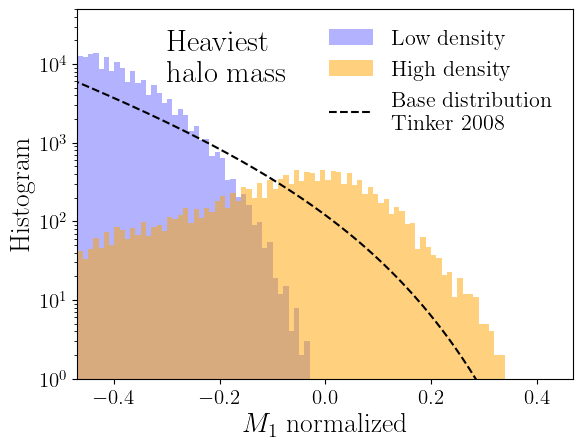

In [13]:
pl.figure()
# _ = pl.hist(Nhalo_train_mg_arr_rs.flatten(), bins=500, range=(0.5,6.5))
indsel = np.where(density_train_rs < 0.5)
_ = pl.hist(M1_norm_rs[indsel].flatten(), bins=100, range=(-0.5,0.5), alpha=0.3, color='blue', label='Low density')

indsel = np.where(density_train_rs > 1.5)
_ = pl.hist(M1_norm_rs[indsel].flatten(), bins=100, range=(-0.5,0.5), alpha=0.5, color='orange', label='High density')

pl.plot(lgM_rescaled, 1e3*hmf_pdf, color='k', ls='--', label='Base distribution' + '\n' + 'Tinker 2008')

pl.text(-0.3, 6.0e3, 'Heaviest' + '\n' + 'halo mass', fontsize=22)

pl.legend(fontsize=16, frameon=False)
pl.yscale('log')
pl.xlabel(r'$M_1$ normalized', size=20)
pl.ylabel('Histogram', size=20)
pl.ylim(1, 5e4)
pl.xlim(-0.47, 0.47)
pl.tick_params(axis='both', labelsize=15)
# pl.savefig('M1_normalized.png', dpi=300, bbox_inches='tight')
pl.savefig('/mnt/home/spandey/ceph/CHARM/results/paper_plots/M1_normalized.pdf', bbox_inches='tight')



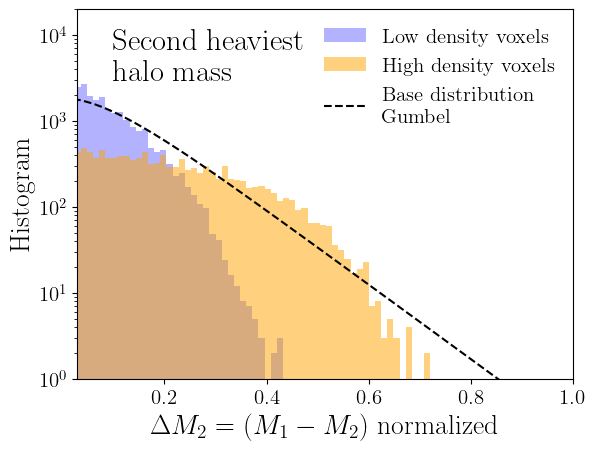

In [14]:
pl.figure()
# _ = pl.hist(Nhalo_train_mg_arr_rs.flatten(), bins=500, range=(0.5,6.5))
indsel = np.where(density_train_rs < 0.5)
_ = pl.hist(Mdiff1_norm_rs[indsel].flatten(), bins=100, range=(0.0,1.2), alpha=0.3, color='blue', label='Low density voxels')

indsel = np.where(density_train_rs > 1.5)
_ = pl.hist(Mdiff1_norm_rs[indsel].flatten(), bins=100, range=(0.0,1.2), alpha=0.5, color='orange', label='High density voxels')

mu, beta = 0, 0.1
x_array = np.linspace(0.0,1.2,1000)
yx = (1/beta)*np.exp(-(x_array - mu)/beta) * np.exp( -np.exp( -(x_array - mu) /beta))
pl.plot(x_array, 5e2*yx, color='k', ls='--', label='Base distribution' + '\n' + 'Gumbel')
pl.text(0.1, 3.0e3, 'Second heaviest' + '\n' + 'halo mass', fontsize=22)
# pl.legend(fontsize=12)
pl.yscale('log')
pl.xlabel(r'$\Delta M_2 = (M_1 - M_2)$ normalized', size=20)
pl.ylabel('Histogram', size=20)
pl.ylim(1, 2e4)
pl.xlim(0.03, 1.0)
pl.tick_params(axis='both', labelsize=15)
pl.legend(fontsize=15, frameon=False)
# pl.savefig('Mdiff1_normalized.png', dpi=300, bbox_inches='tight')
pl.savefig('/mnt/home/spandey/ceph/CHARM/results/paper_plots/Mdiff1_normalized.pdf', bbox_inches='tight')


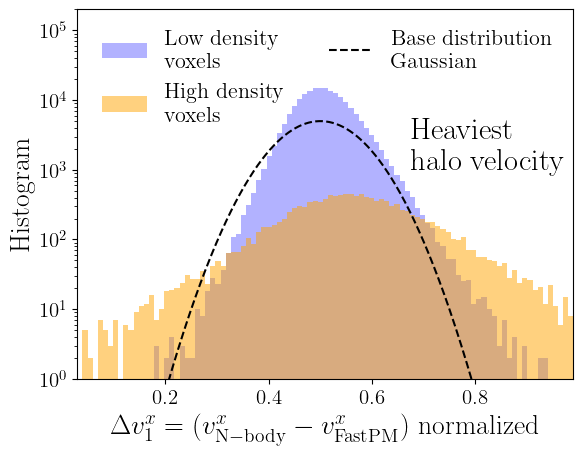

In [15]:
pl.figure()
# _ = pl.hist(Nhalo_train_mg_arr_rs.flatten(), bins=500, range=(0.5,6.5))
indsel = np.where(density_train_rs < 0.5)
_ = pl.hist(vhalos_diff_norm_rs[indsel].flatten(), bins=100, range=(0.0,0.99), alpha=0.3, color='blue', label='Low density' + '\n' + 'voxels')

indsel = np.where(density_train_rs > 1.5)
_ = pl.hist(vhalos_diff_norm_rs[indsel].flatten(), bins=100, range=(0.0,0.99), alpha=0.5, color='orange', label='High density' + '\n' + 'voxels')

mu, sigma = 0.5, 0.04
x_array = np.linspace(0.0,1.1,1000)

yx = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x_array - 0.5)**2 /(2*np.pi *sigma**2))
pl.plot(x_array, 5e2*yx, color='k', ls='--', label='Base distribution' + '\n' + 'Gaussian')
# pl.text(0.1, 4.0e3, 'Second heaviest' + '\n' + 'halo mass', fontsize=16)
# pl.legend(fontsize=12)
pl.yscale('log')
pl.xlabel(r'$\Delta v_1^x = (v^x_{\rm N-body} - v^{x}_{\rm FastPM})$ normalized', size=20)
pl.ylabel('Histogram', size=20)
pl.ylim(1, 2e5)
pl.xlim(0.03, 0.99)
pl.tick_params(axis='both', labelsize=15)
pl.legend(fontsize=16, frameon=False, ncol=2)
pl.text(0.675, 1.0e3, 'Heaviest' + '\n' + 'halo velocity', fontsize=22)
# pl.savefig('Mdiff1_normalized.png', dpi=300, bbox_inches='tight')
pl.savefig('/mnt/home/spandey/ceph/CHARM/results/paper_plots/vdiff1_normalized.pdf', bbox_inches='tight')


